In [1]:
using HDF5
using JSON
using Plots, LinearAlgebra, Statistics, Random, StatsBase, Compat, Distributions

data = Dict()

filenames = ["mcmc_electron.hdf5"];


# d = Uniform(0, 35)
# data_samples = Array{Float64, 1}()
# counter = 0
# while counter < 10000
#     x = rand(d)
#     if abs(x) <= 30.5
#         counter += 1
#         push!(data_samples, convert(Int, round(x)))
#     end
# end
# u=unique(data_samples)
# thetas=Dict([(i,count(x->x==i,data_samples)) for i in u])

theta_distr = []

for filename in filenames
    println(filename)
    ligo = h5open(filename, "r")

    for elem in names(ligo)
        m = ligo[elem]
        j = JSON.parse(read(m)["meta"])
        data_array = [elem.data[1] for elem in read(m)["deposit"]]
        energy_value = j["values"]["macros"]["energy"]
        theta = j["values"]["macros"]["theta"]
        if theta == 0 && energy_value > 4
            if !haskey(data, energy_value)
                data[energy_value] = []
            end
            append!(data[energy_value], data_array)
        end
    end

    close(ligo)
end

# for energy in keys(data)
#     Random.shuffle!(data[energy])
# end

mcmc_electron.hdf5


In [2]:
data_p = Dict()

filenames = ["mcmc_1_69.hdf5", "mcmc_70_99.hdf5", "mcmc_100_119.hdf5",
"mcmc_120_139.hdf5", "mcmc_140_150.hdf5"];

theta_distr = []

for filename in filenames
    println(filename)
    ligo = h5open(filename, "r")

    for elem in names(ligo)
        m = ligo[elem]
        j = JSON.parse(read(m)["meta"])
        data_array = [elem.data[1] for elem in read(m)["deposit"]]
        energy_value = j["values"]["macros"]["energy"]
        theta = j["values"]["macros"]["theta"]
        if theta == 0 && energy_value > 4
            if !haskey(data_p, energy_value)
                data_p[energy_value] = []
            end
            append!(data_p[energy_value], data_array)
        end
    end

    close(ligo)
end


mcmc_1_69.hdf5
mcmc_70_99.hdf5
mcmc_100_119.hdf5
mcmc_120_139.hdf5
mcmc_140_150.hdf5


In [3]:
include("../../statreg_materials/StatReg.jl/src/StatReg.jl")
using .StatReg


plotly()
gr(size=(500,500), html_output_format=:png)

GLOBAL_RNG = 123
Random.seed!(123);

In [4]:
using Memoize
@memoize function K(E, y)
    return mean([elem[y] for elem in data[E]])
end
@memoize function K_p(E, y)
    return mean([elem[y] for elem in data_p[E]])
end

energy = sort(collect(keys(data)));
energy_p = sort(collect(keys(data_p)));
ln_energy = log.(energy);
ln_energy_p = log.(energy_p);

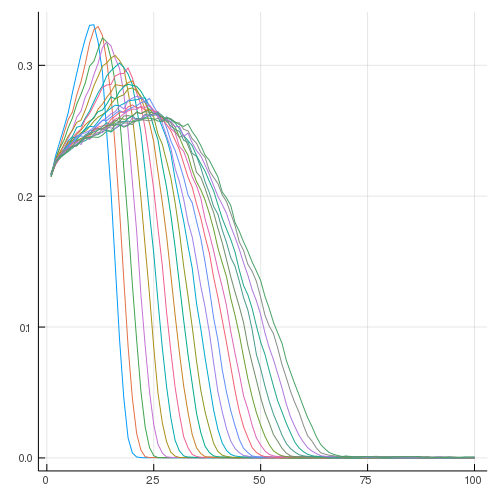

In [5]:
p = plot()
for e in energy
    p = plot!(collect(range(1, stop=100)), [K(e, y_) for y_ in collect(range(1, stop=100))], label="")
end
display(p)

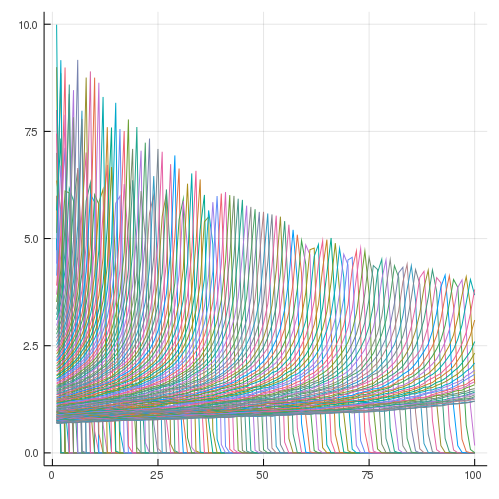

In [6]:
p = plot()
for e in energy_p
    p = plot!(collect(range(1, stop=100)), [K_p(e, y_) for y_ in collect(range(1, stop=100))], label="")
end
display(p)

In [7]:
function create_spectrum(n_energy, energy)
    arr = []
#     for (key, value) in data
#         n = n_energy[floor(Int, key*10)]
#         data_arr = sample(value, n)
#         append!(arr, data_arr)
#     end
    for (n, i) in zip(n_energy, energy)
        value = data[i]
        data_arr = sample(value, n)
        append!(arr, data_arr)
    end
    return sum(arr)
end

create_spectrum (generic function with 1 method)

In [8]:
function create_spectrum_p(n_energy, energy_p)
    arr = []
#     for (key, value) in data
#         n = n_energy[floor(Int, key*10)]
#         data_arr = sample(value, n)
#         append!(arr, data_arr)
#     end
    for (n, i) in zip(n_energy, energy_p)
        value = data_p[i]
        data_arr = sample(value, n)
        append!(arr, data_arr)
    end
    return sum(arr)
end

create_spectrum_p (generic function with 1 method)

In [9]:
function real_spectrum_p(E)
#     C = 3.26 * 10^7
#     ga = 0.87
#     gb = 4.68
#     E0 = 12.8
#     dt = 1.44 * 10^5
    C = 1.35 * 10^9
    ga = 1.04
    gb = 3.52
    E0 = 27.4
    dt = 1.19 * 10^5
    S = 10
    
    if E < (gb - ga) * E0
        return C * E^(-ga) * exp(- E / E0) / dt * S #* E
    else
        return C * E^(-gb) * ((gb-ga) * E0)^(gb-ga) * exp(ga-gb) / dt * S #* E
    end
end

function real_spectrum(E)
    Ca = 6.58 * 10^8 #* 10^3
    Cb = 1.46 * 10^8 #* 10^3
    ga = 1.90
    gb = 4.27
    dt = 1.19 * 10^5
    E0 = 0.5
    S = 10
#     Ca = 1.08 * 10^7
#     Cb = 1.67 * 10^7
#     ga = 1.50
#     gb = 3.98
#     dt = 2.27 * 10^5
#     E0 = 1.32
#     S = 10
    if E < E0
        return Ca * E^(-ga) / dt * S
    else
        return Cb * E^(-gb) / dt * S
    end
end


real_spectrum (generic function with 1 method)

In [10]:
arr_spectrum_real = [floor(Int, real_spectrum(x_)) for x_ in energy]
f_y = create_spectrum(arr_spectrum_real, energy);

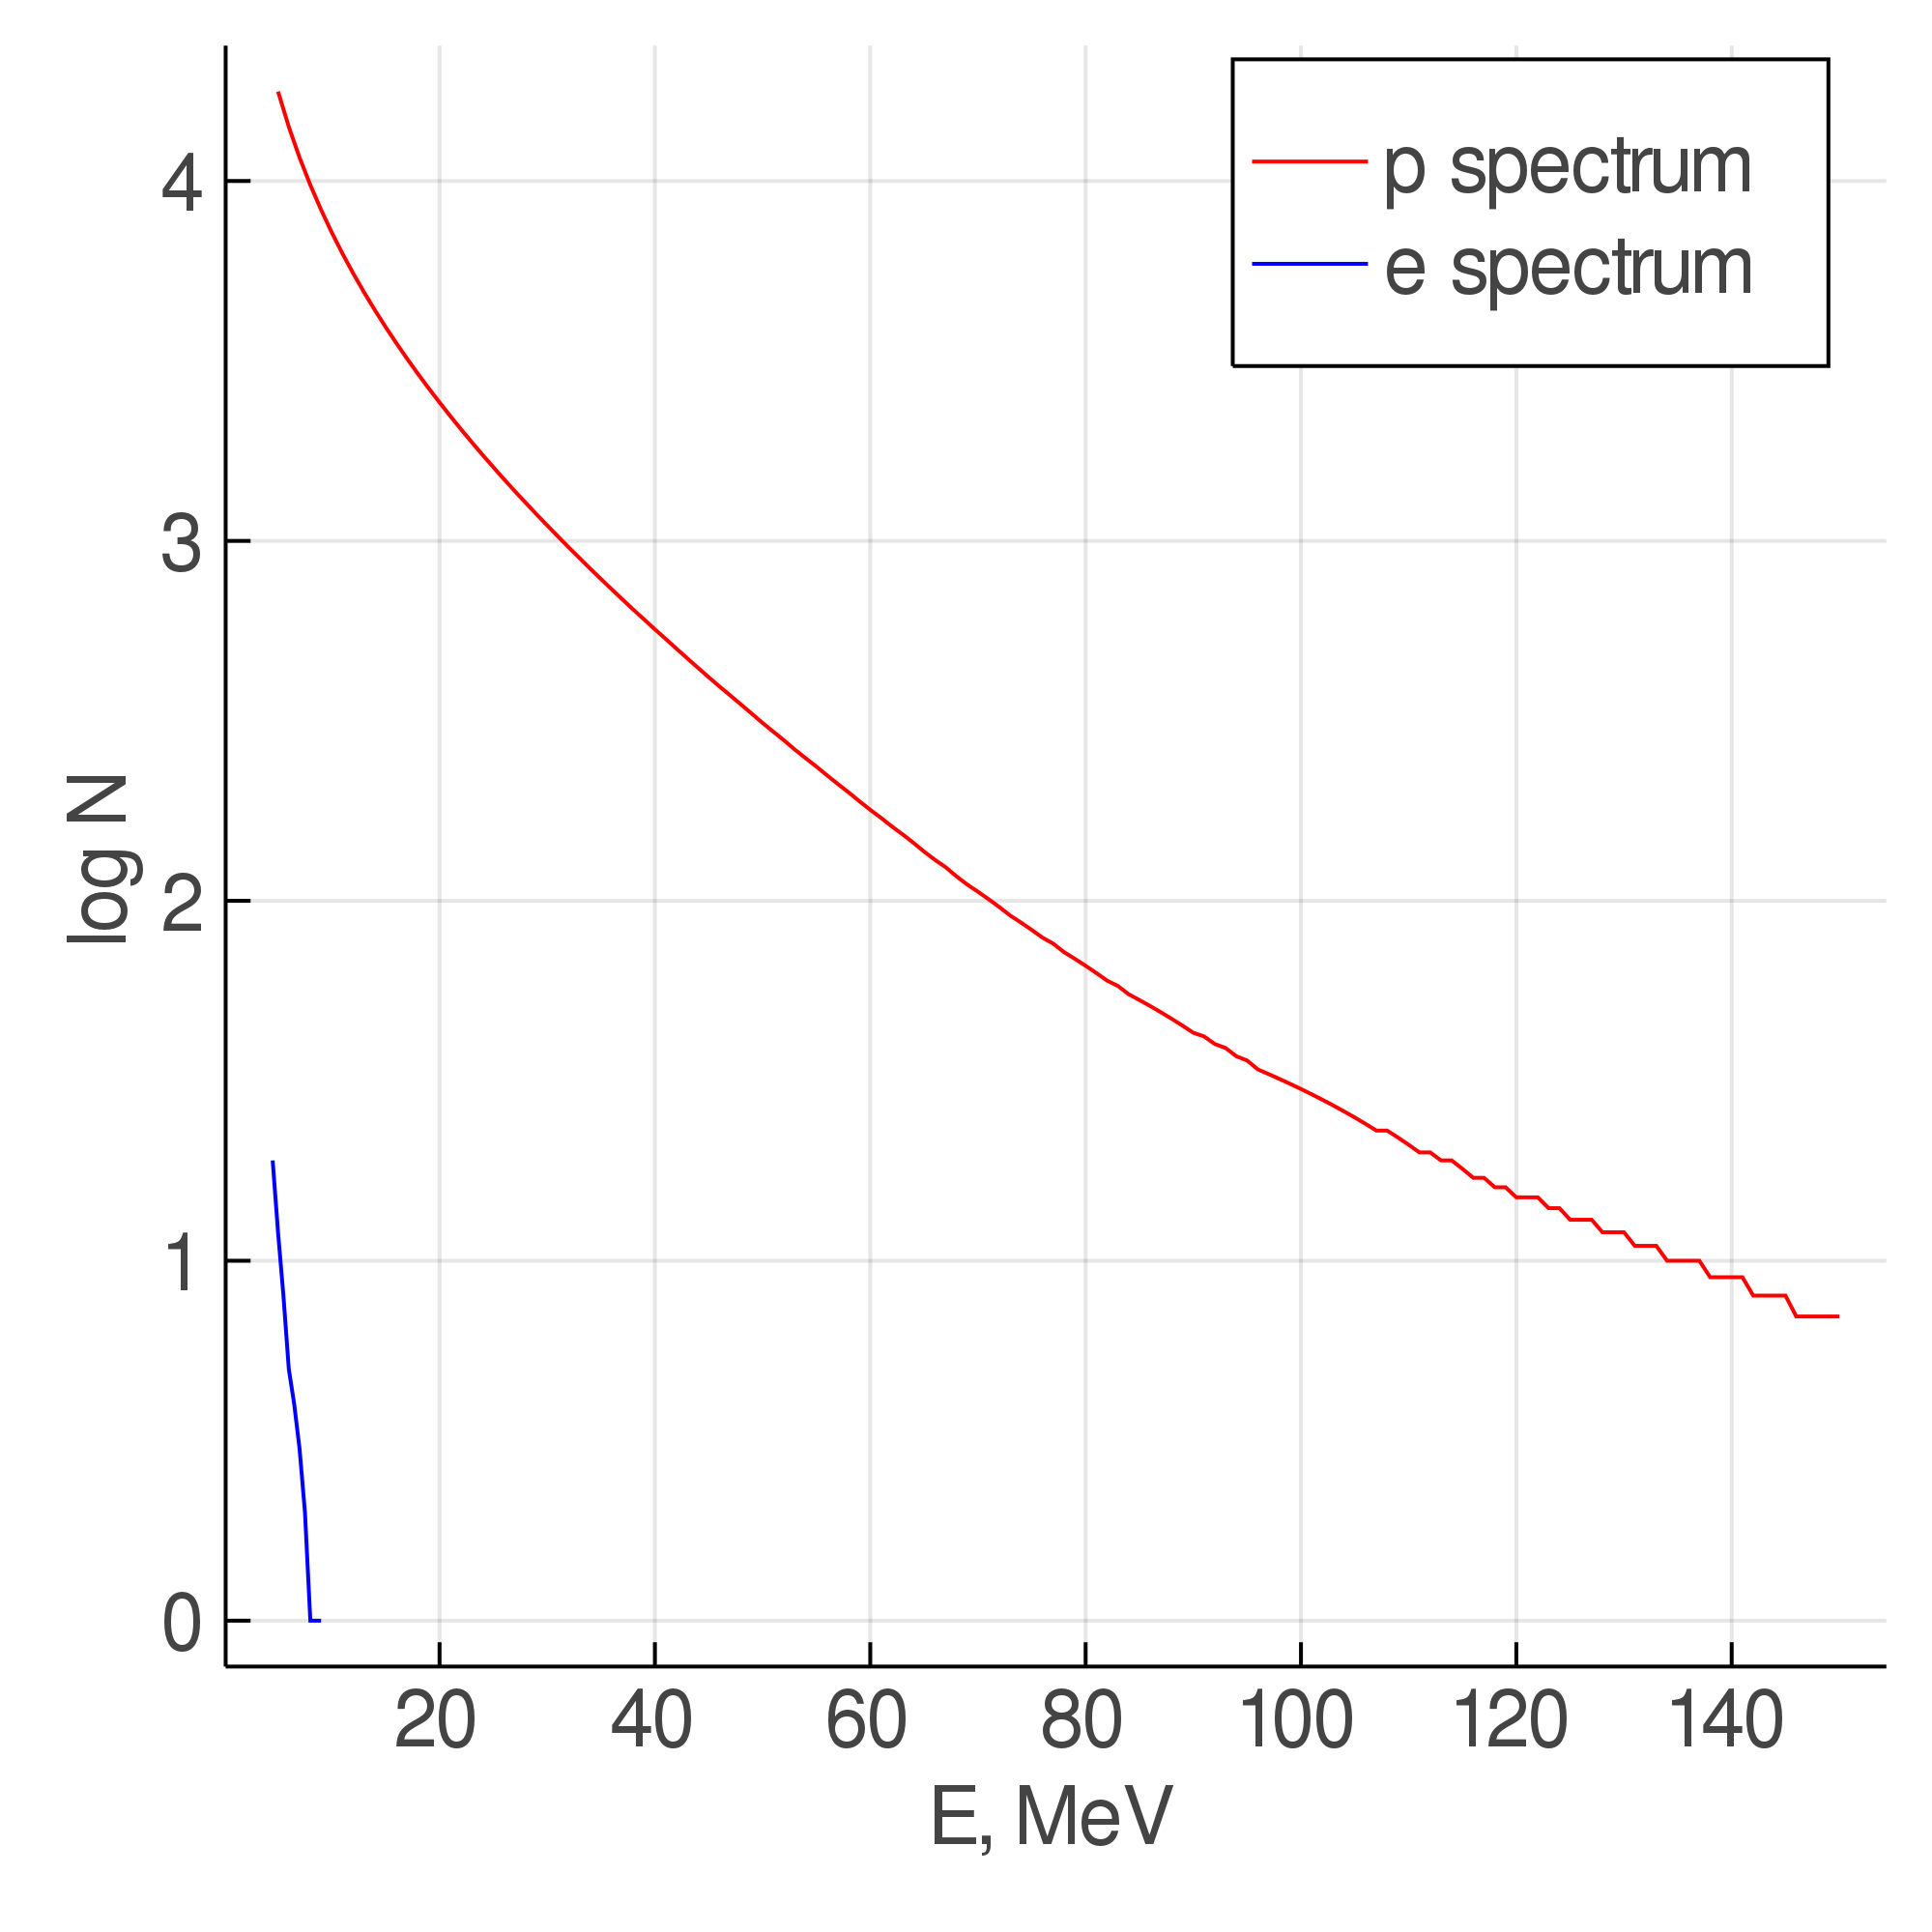

In [11]:
arr_spectrum_real_p = [floor(Int, real_spectrum_p(x_)) for x_ in energy_p]
f_y_p = create_spectrum_p(arr_spectrum_real_p, energy_p);

log_arr_spectrum_real_p = log.(10, arr_spectrum_real_p)
log_arr_spectrum_real = log.(10, arr_spectrum_real)

plot(energy_p, log_arr_spectrum_real_p, label="p spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red)
plot!(energy, log_arr_spectrum_real, label="e spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
    xlabel="E, MeV", ylabel="log N")
# savefig("p_e_log_spectra.png")

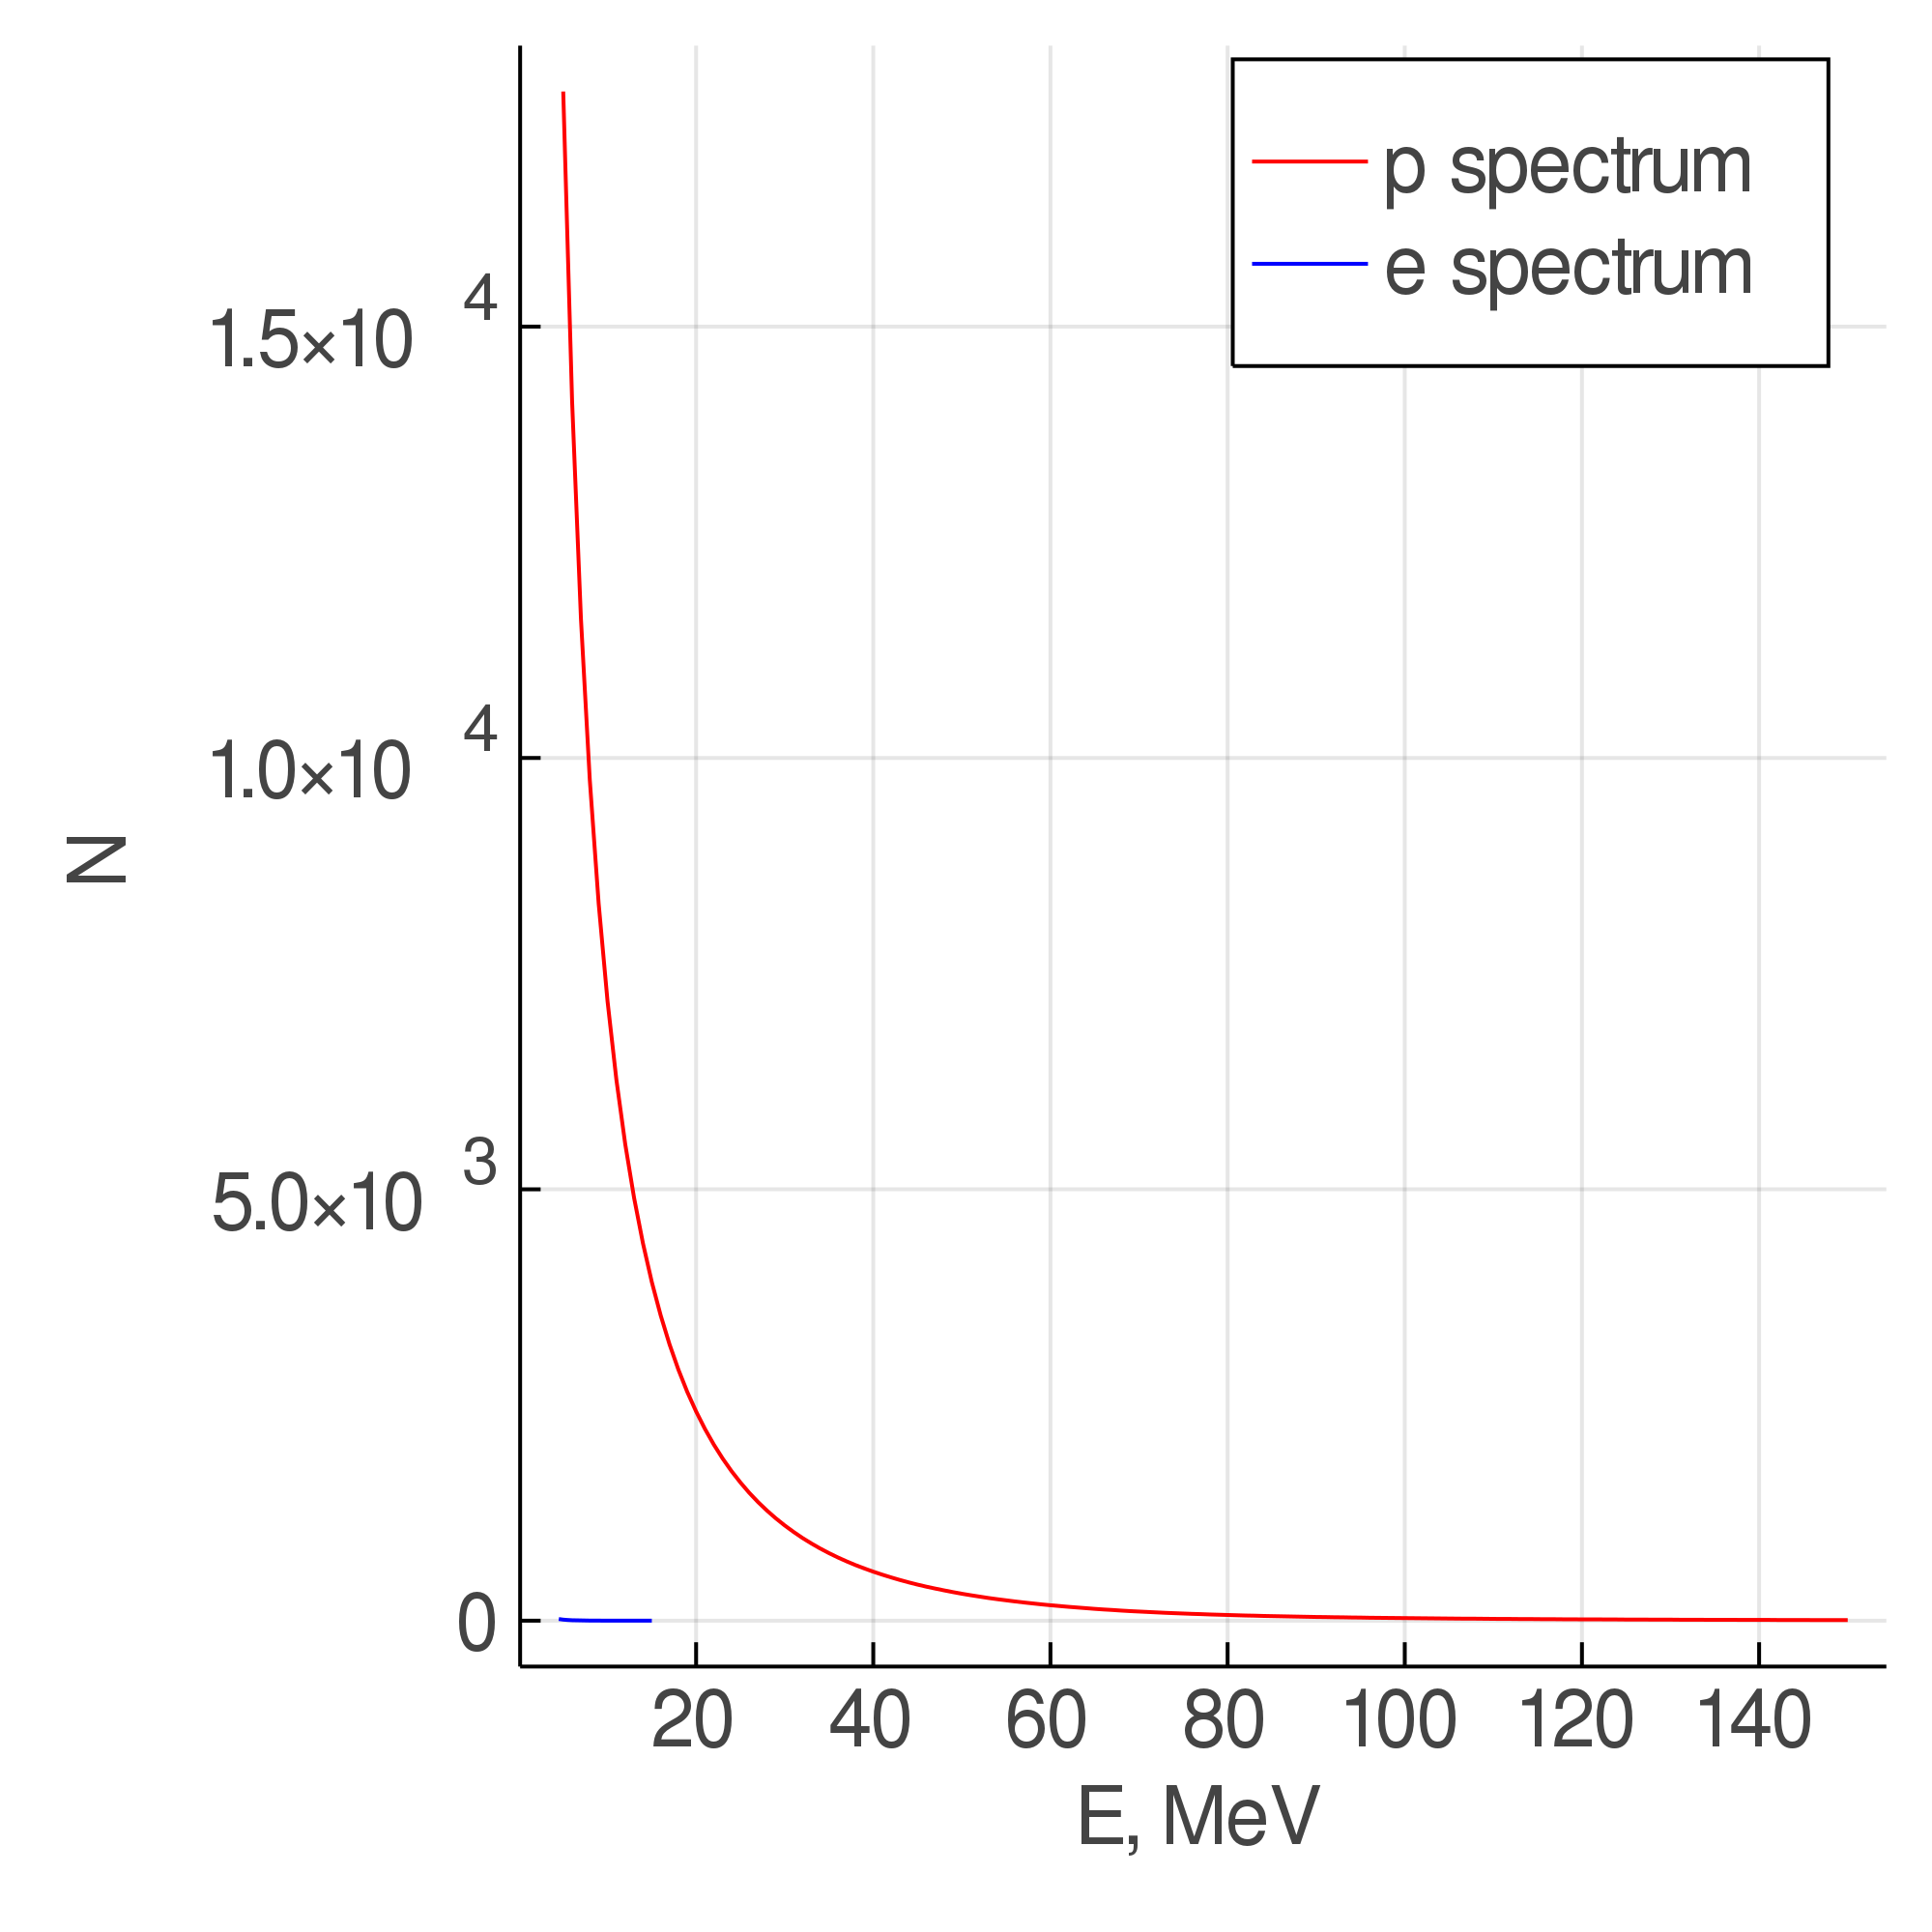

In [12]:
plot(energy_p, arr_spectrum_real_p, label="p spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red)
plot!(energy, arr_spectrum_real, label="e spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
    xlabel="E, MeV", ylabel="N")
# savefig("p_e_spectra.png")

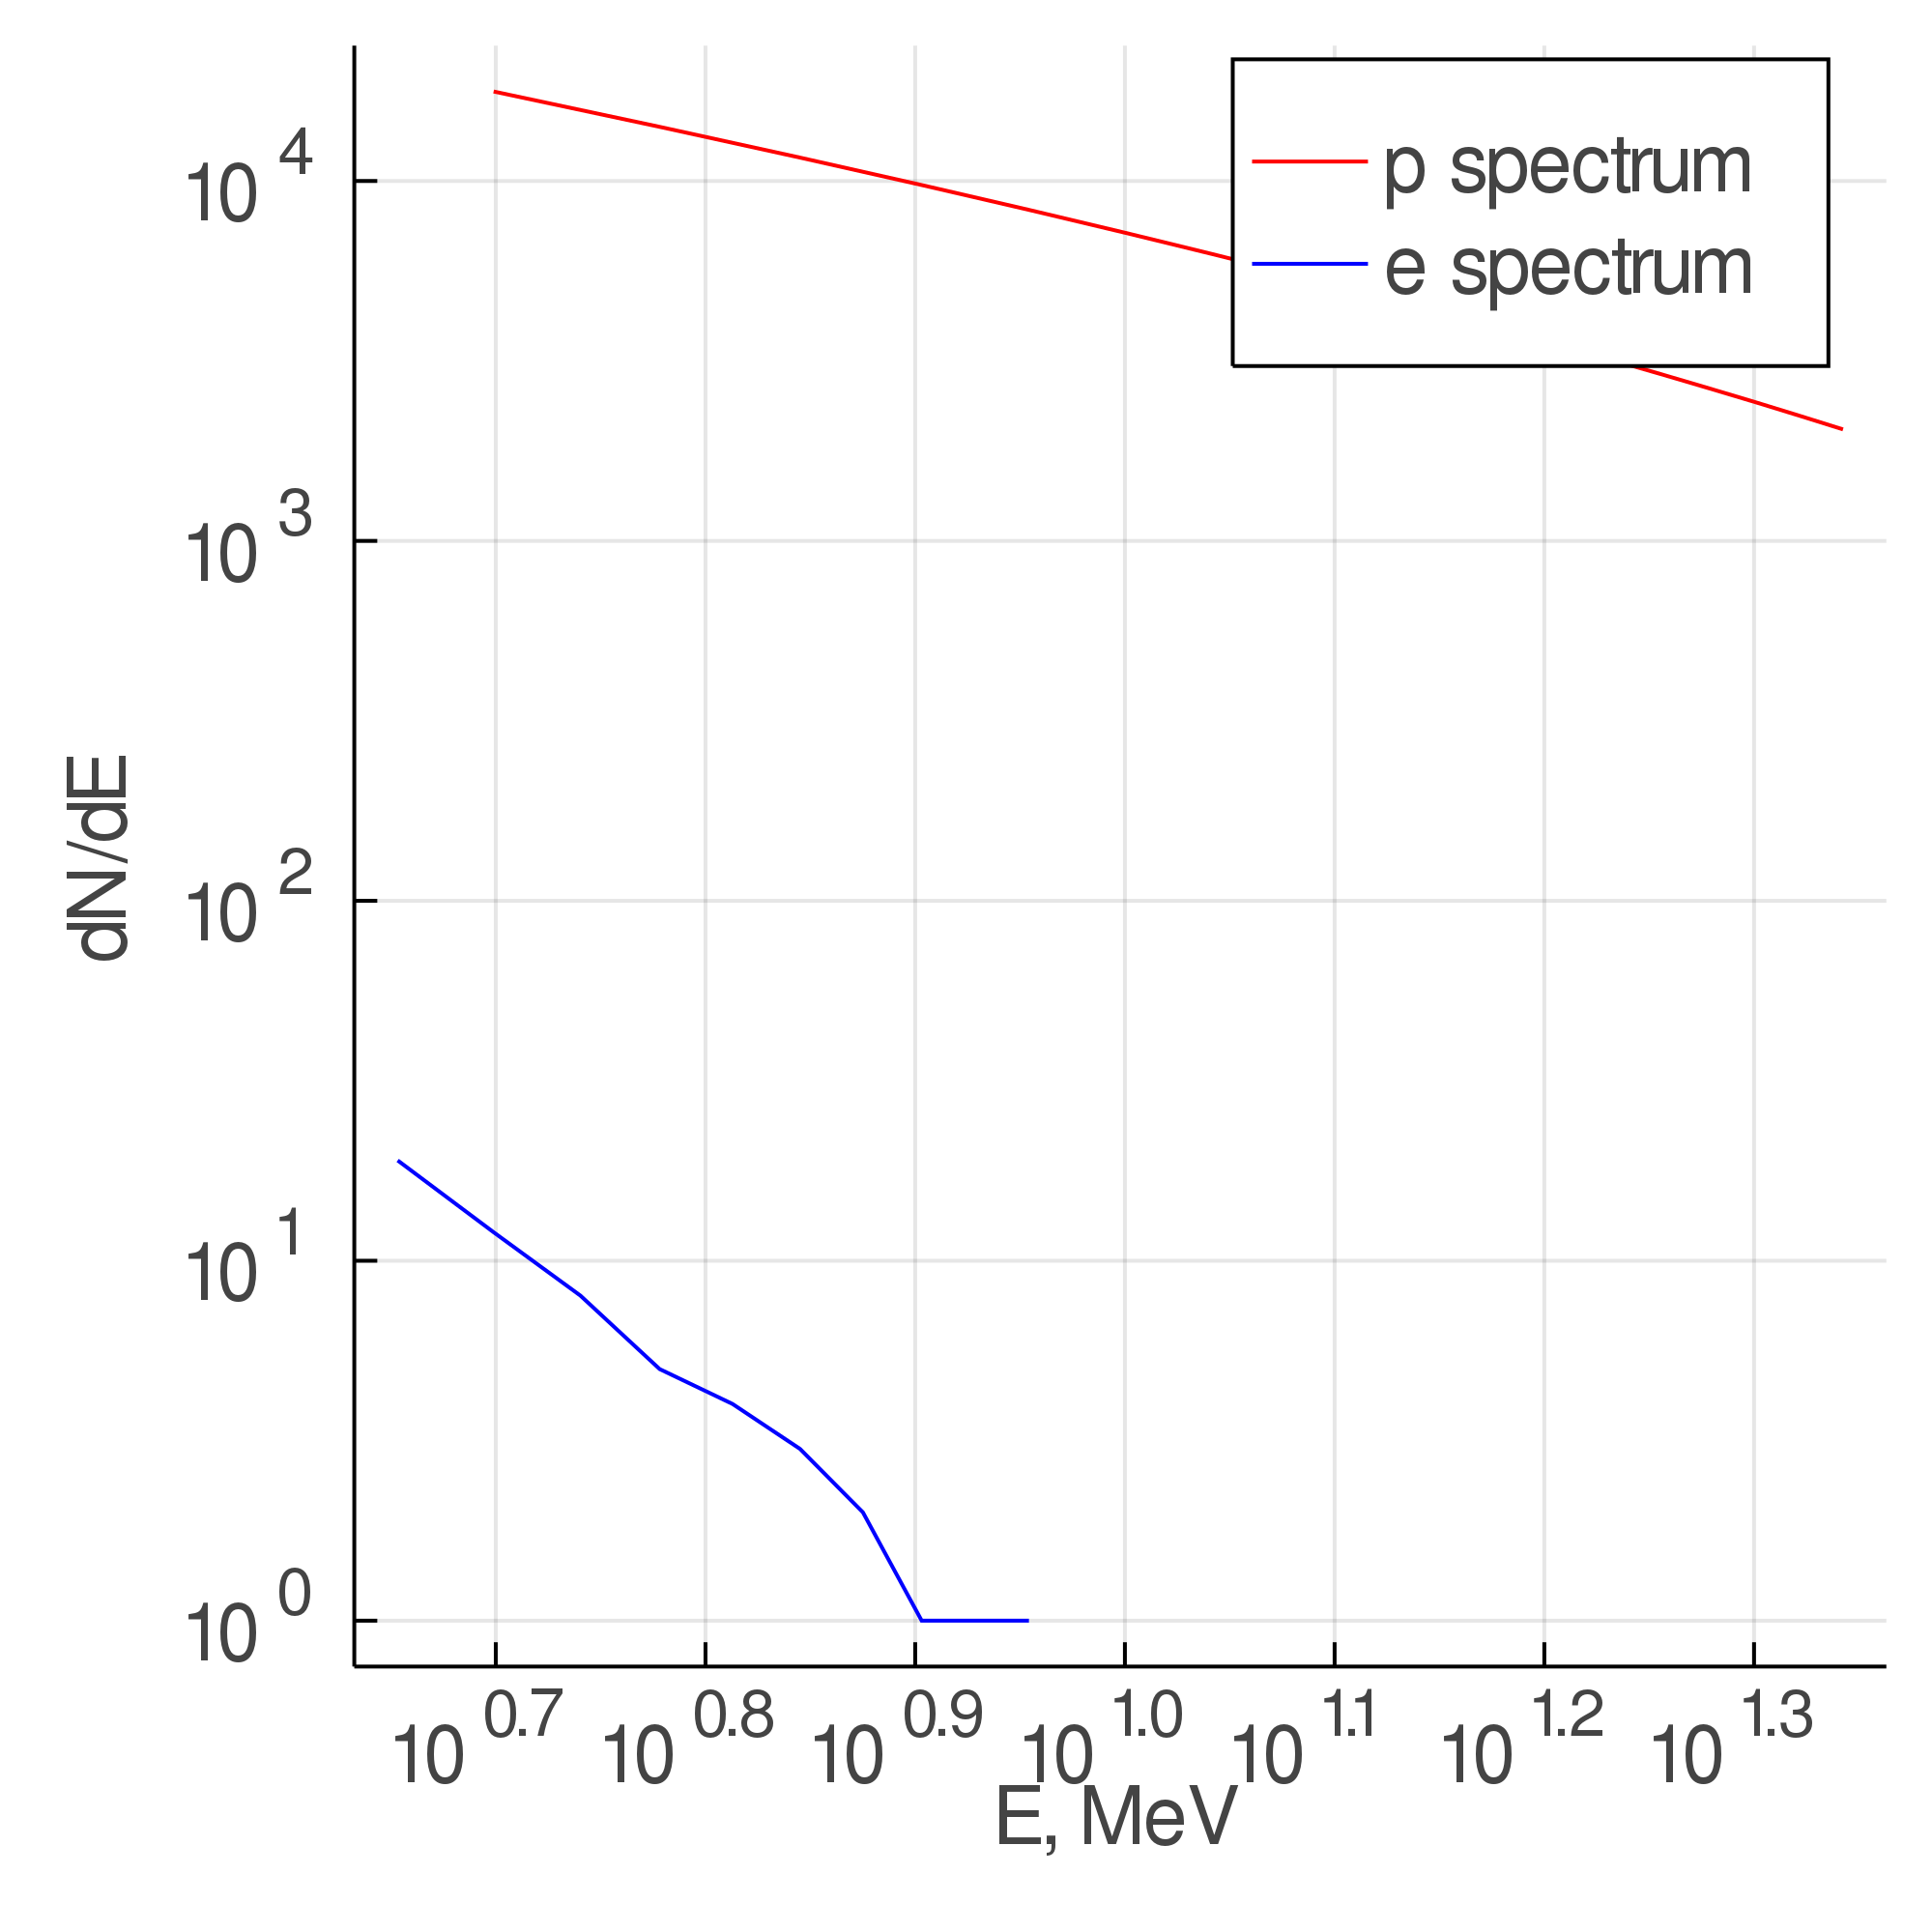

In [13]:
plot(energy_p[1:18], arr_spectrum_real_p[1:18], label="p spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red,
    xscale = :log10, yscale = :log10)
plot!(energy[1:10], arr_spectrum_real[1:10], label="e spectrum", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
    xlabel="E, MeV", ylabel="dN/dE", xscale = :log10, yscale = :log10)
# savefig("p_e_loglog_spectra.png")

In [14]:
println(sum(arr_spectrum_real_p))
println(sum(arr_spectrum_real))

142315
56


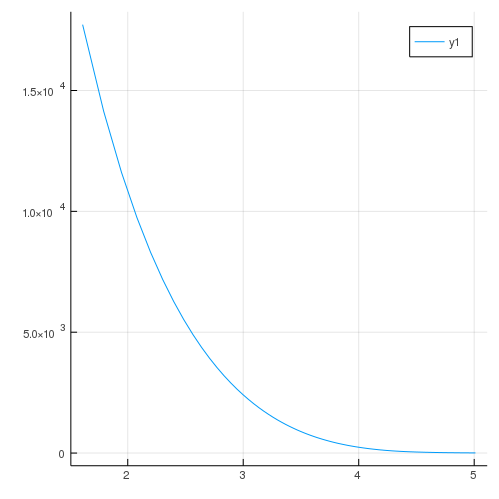

In [15]:
ln_energy_p = log.(energy_p)
plot(ln_energy_p, arr_spectrum_real_p)

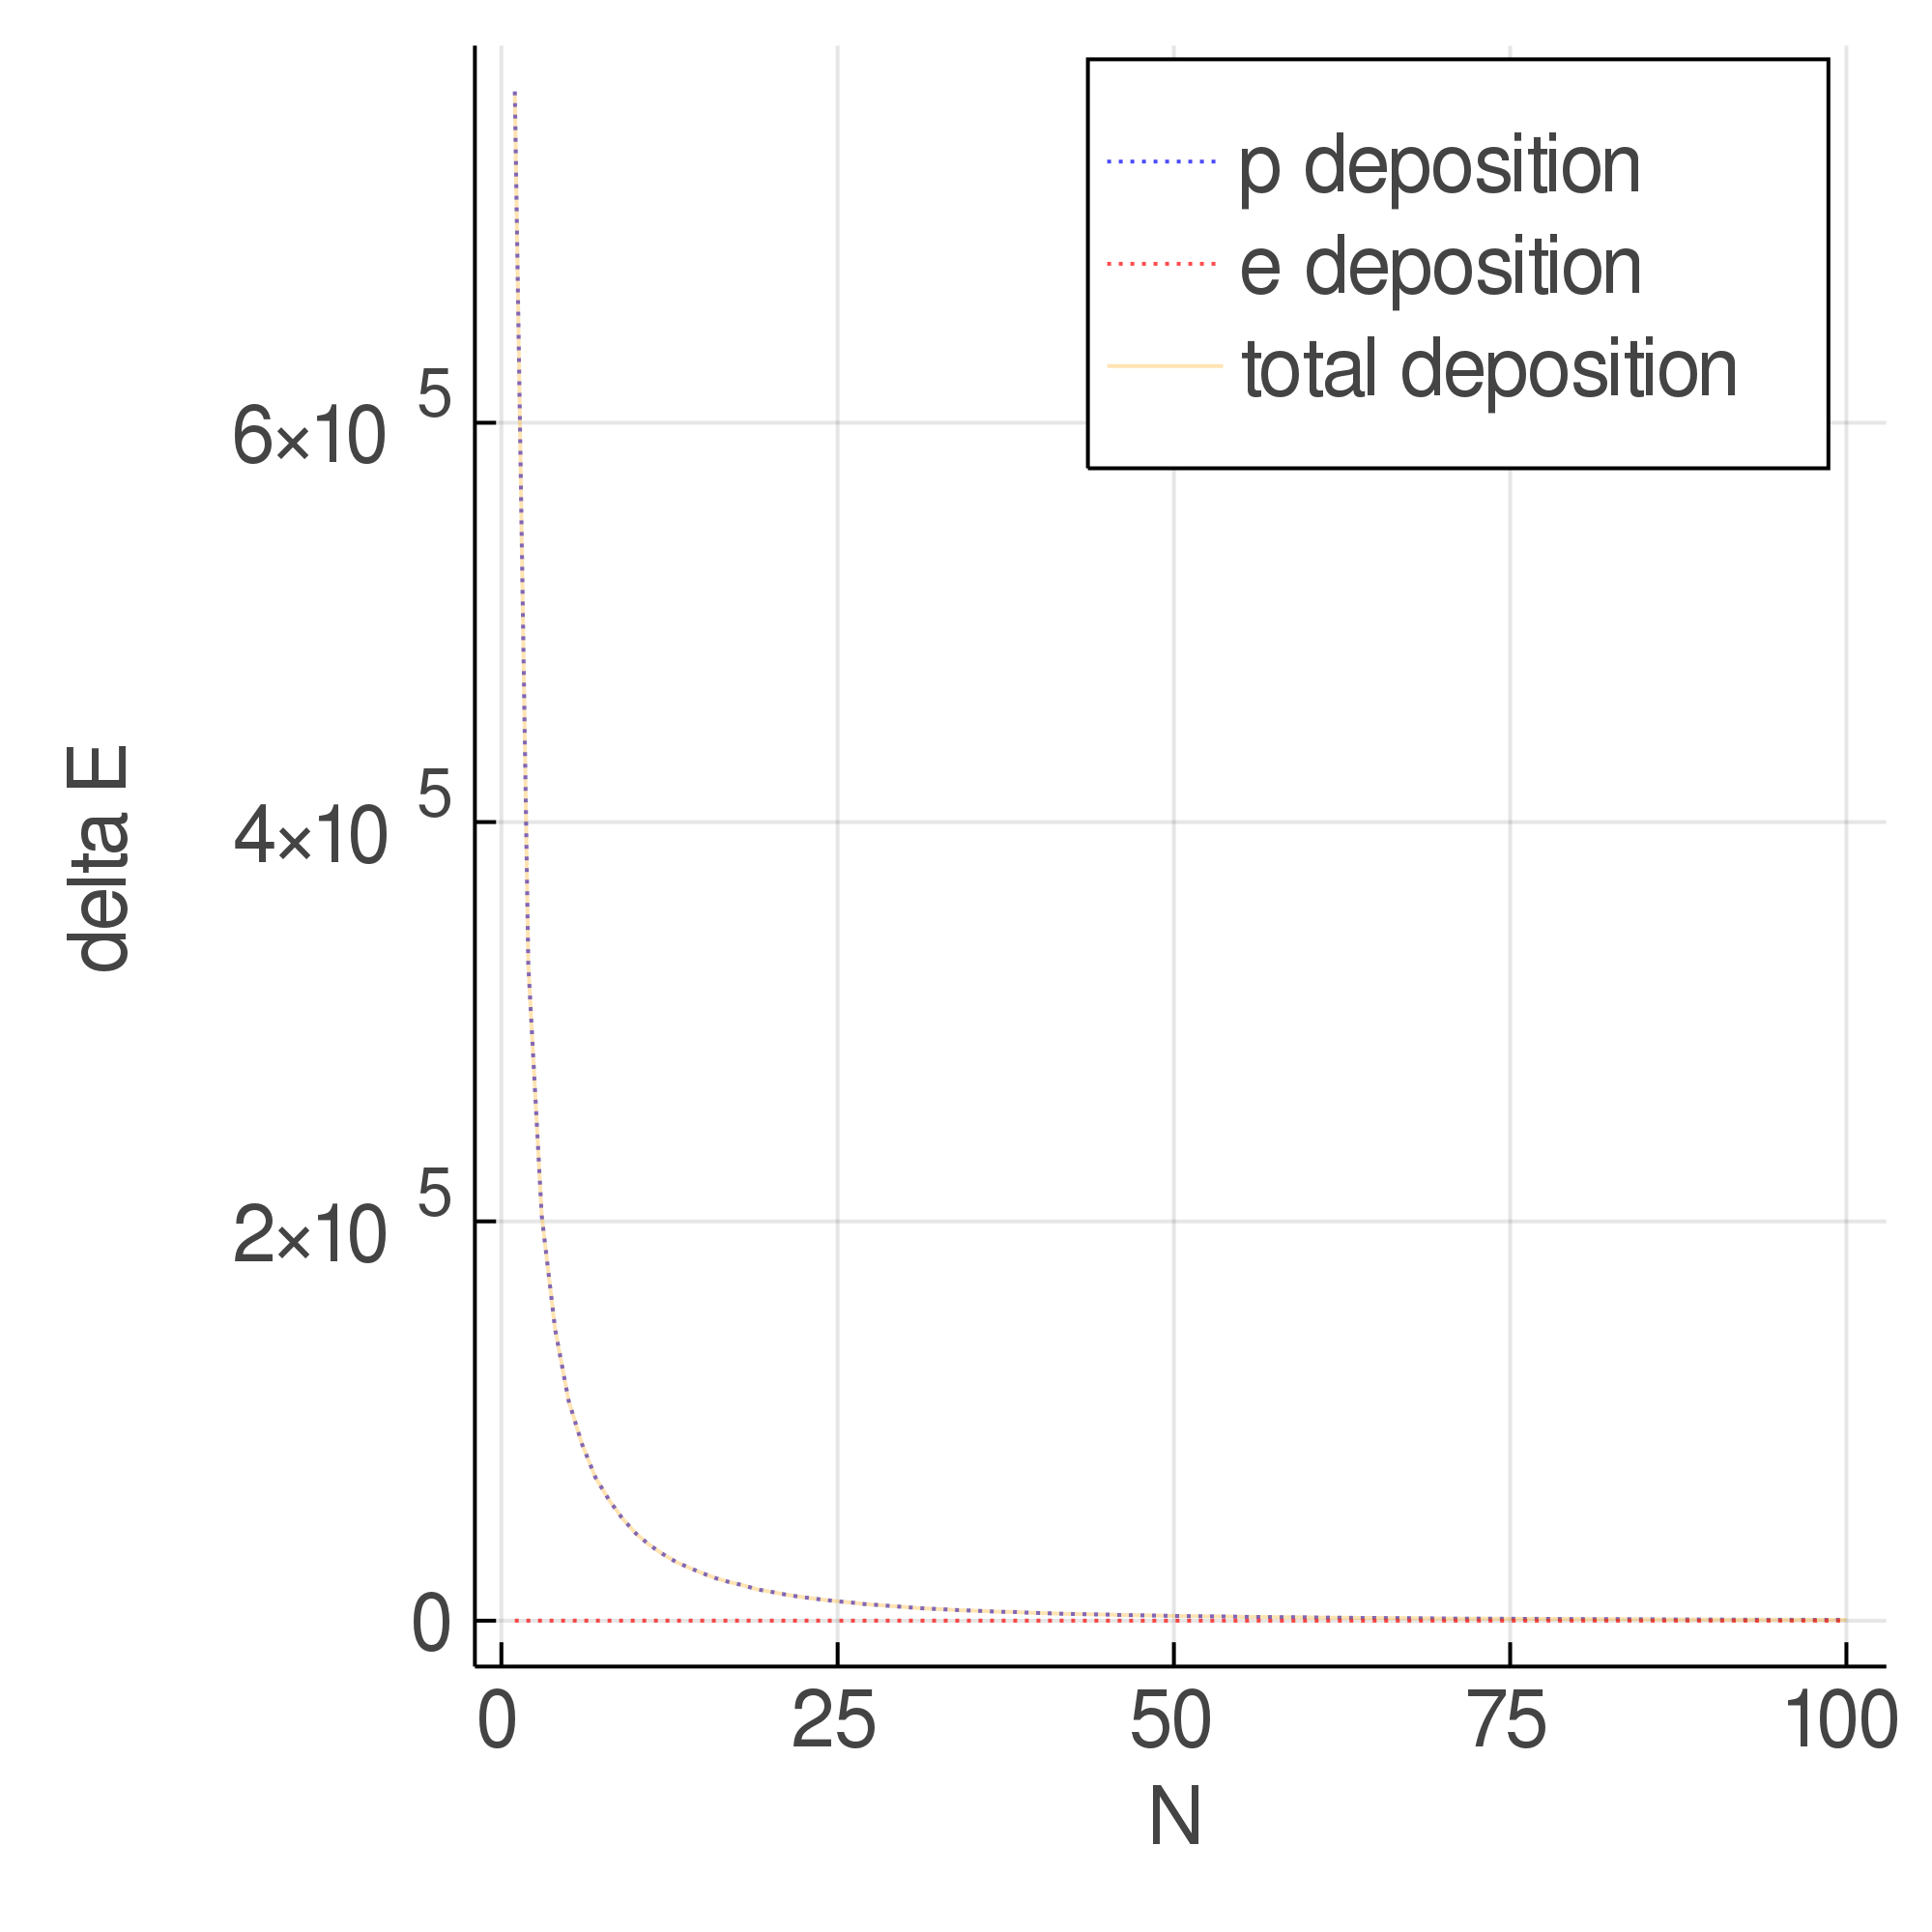

In [16]:
# plot(f_y_p)
# plot!(f_y)

# f_y_corrected = [max(f, 1) for f in f_y]
# println(f_y_corrected)

# plot(log.(10, f_y_p), label="p response", dpi=400,
#     xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red)
# plot!(log.(10, f_y_corrected), label="e response", dpi=400,
#     xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
#     xlabel="N", ylabel="log delta(E)")
# savefig("p_e_log_response.png")

plot(f_y_p, label="p deposition", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue, linestyle=:dot,
    alpha=0.7)
plot!(f_y, label="e deposition", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :red,
    xlabel="N", ylabel="delta E", linestyle=:dot, alpha=0.7)
plot!(f_y_p, label="total deposition", dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :orange, alpha=0.3)
# savefig("deposition.png")

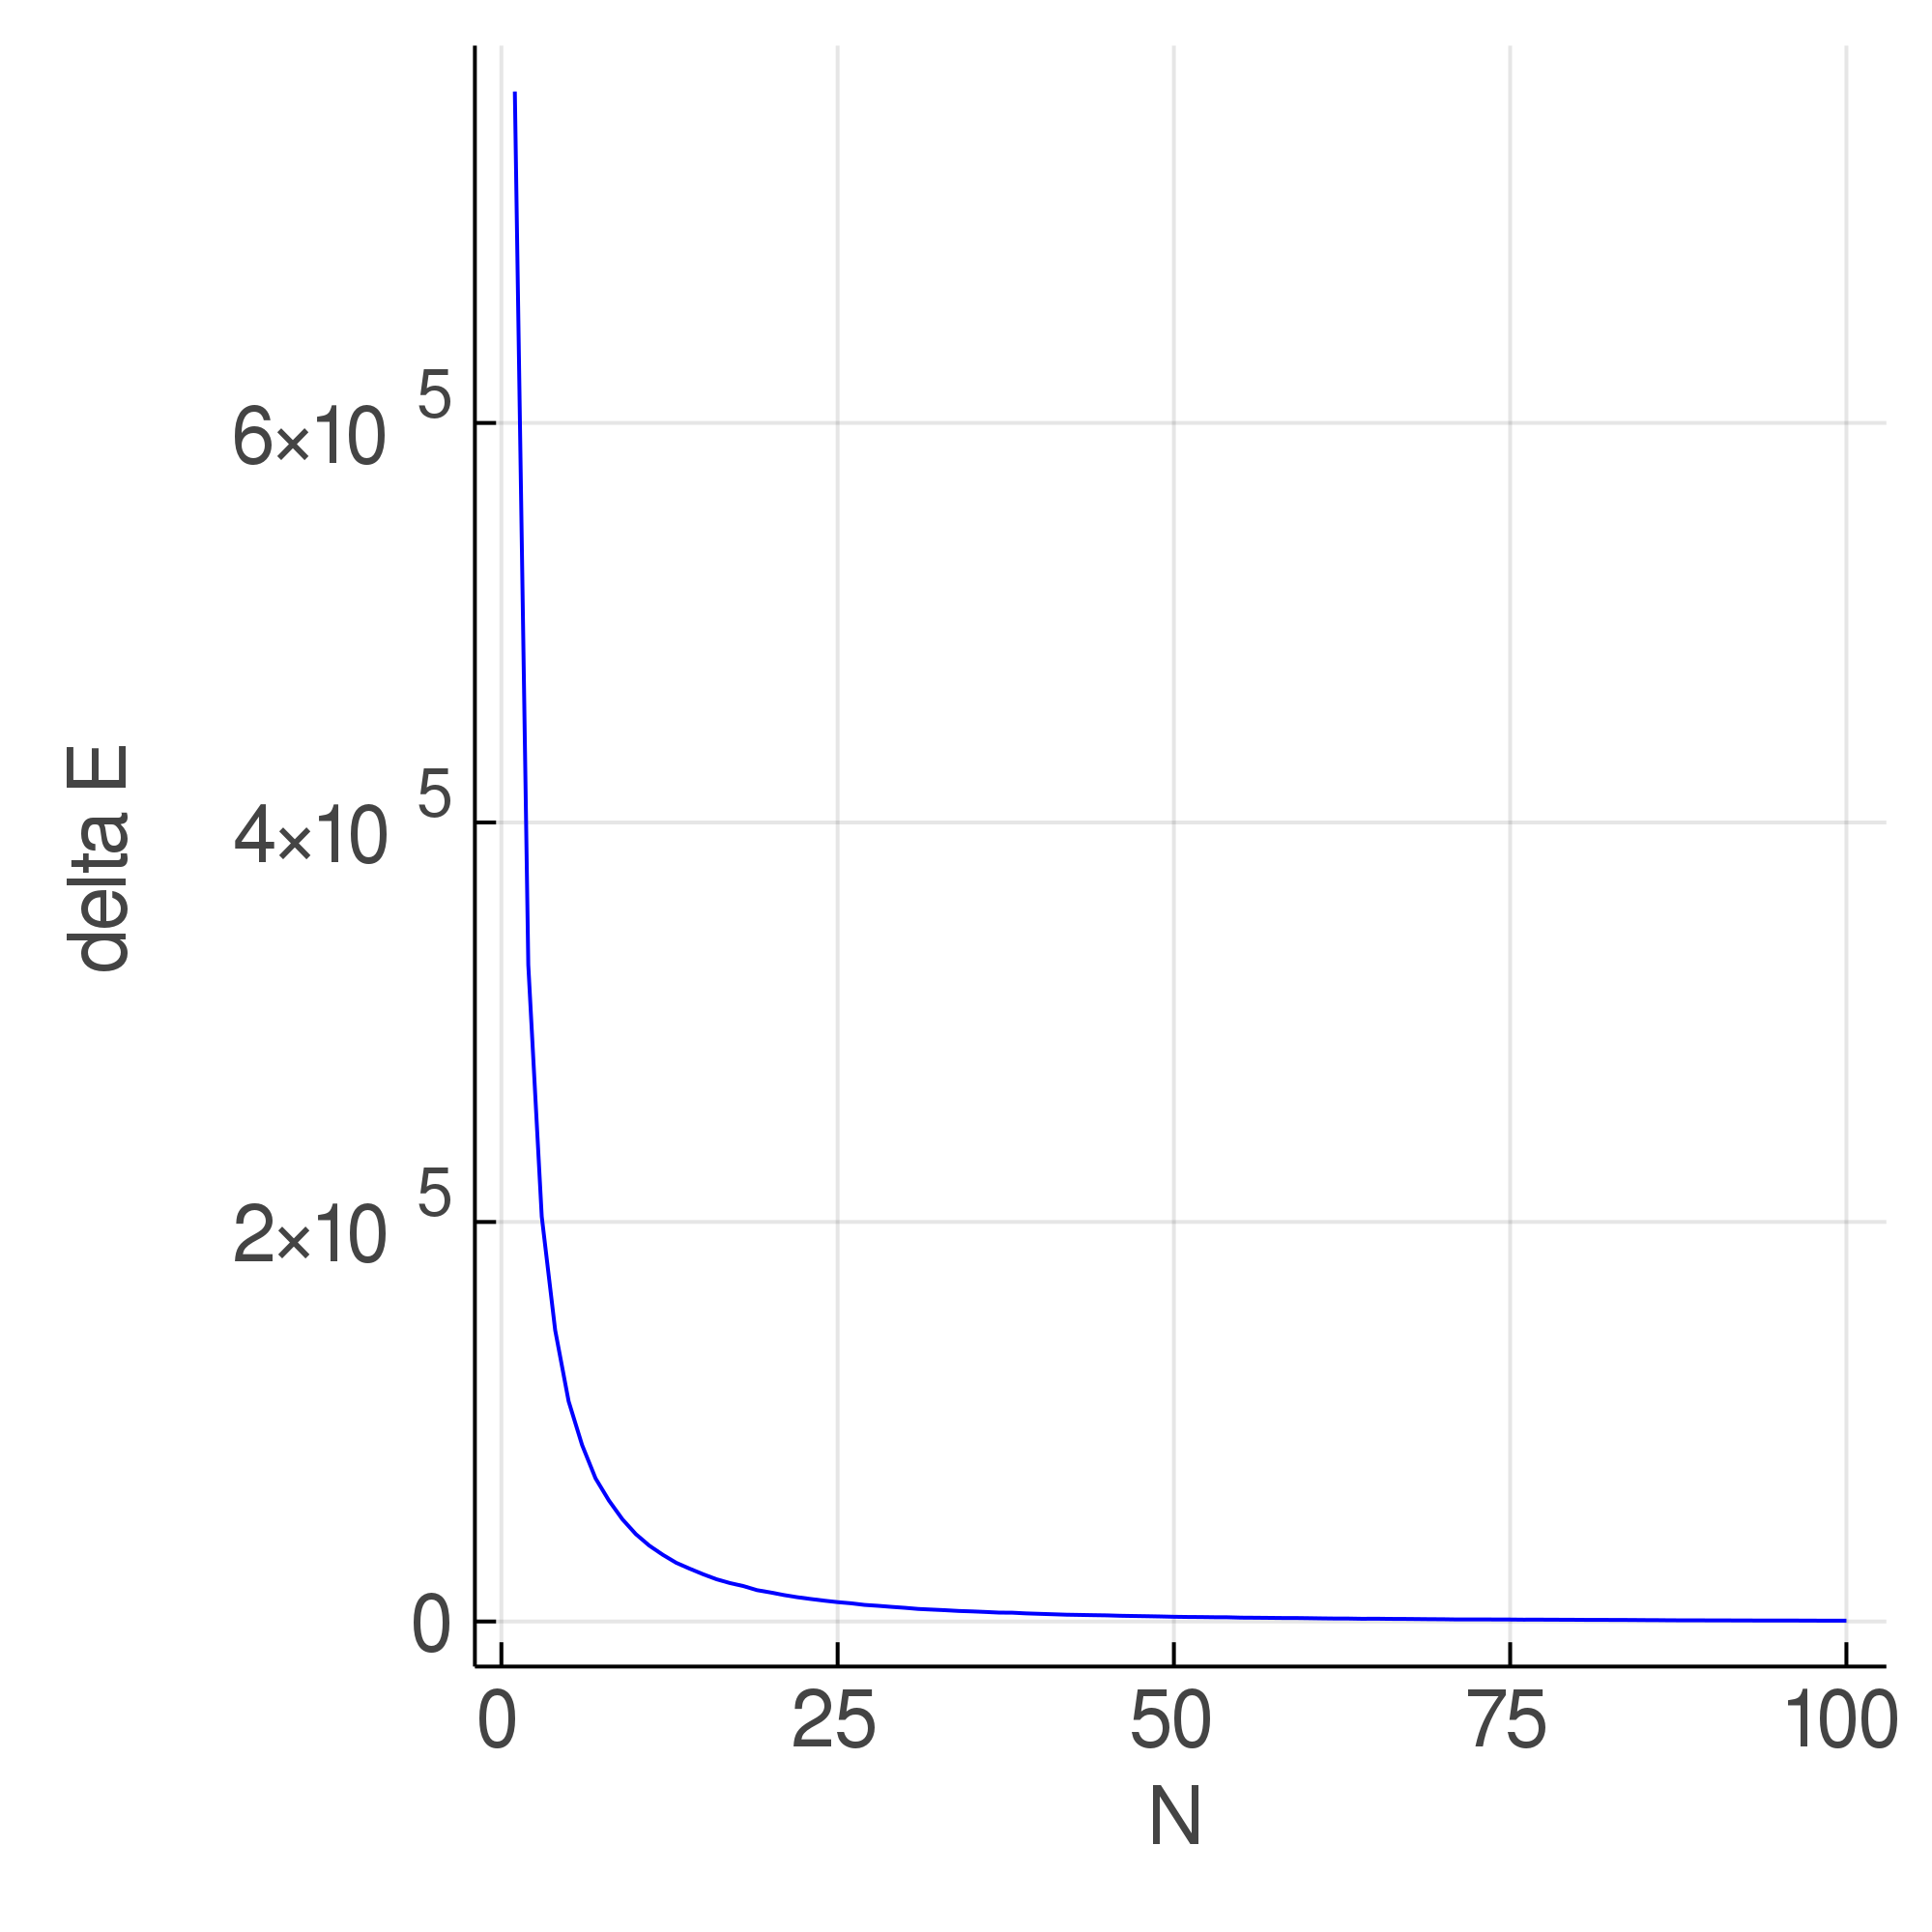

In [17]:
plot(f_y + f_y_p, dpi=400,
    xtickfontsize=14 ,ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue,
    xlabel="N", ylabel="delta E", label="")
# savefig("p_e_sum_response.png")

In [18]:
@memoize function K_cont(E, y)
    if E in energy
        return K(E, y)
    end
    E_max = energy[findfirst(x -> x>=E, energy)]
    E_min = energy[findlast(x -> x<=E, energy)]
    return (K(E_min, y) * (E_max - E) + K(E_max, y) * (E - E_min)) / (E_max - E_min)
end

@memoize function K_cont_ln(E, y)
    return K_cont(exp(E), y) * exp(E)
end

K_cont_ln (generic function with 1 method)

In [19]:
@memoize function K_cont_p(E, y)
    if E in energy_p
        return K(E, y)
    end
    E_max = energy_p[findfirst(x -> x>=E, energy_p)]
    E_min = energy_p[findlast(x -> x<=E, energy_p)]
    return (K_p(E_min, y) * (E_max - E) + K_p(E_max, y) * (E - E_min)) / (E_max - E_min)
end

@memoize function K_cont_p_ln(E, y)
    return K_cont_p(exp(E), y) * exp(E)
end

K_cont_p_ln (generic function with 1 method)

In [20]:
sig = 0.01*f_y + [max(sqrt(i), 1) for i in f_y]
f = f_y + f_y_p;
# plot(f, ribbon=sig, fillalpha=0.3, xlabel="y", ylabel="f", label="", dpi=400,
#     xtickfontsize=14, ytickfontsize=14, legendfontsize=14, guidefont=font(14), color = :blue)
# savefig("f_y_cont.png")

In [21]:
E_min = 1
E_max = 150
a = log(E_min)
b = log(E_max)
basis = CubicSplineBasis(a, b, 60, (nothing, "dirichlet"));
Omega = omega(basis);


┌ Info: Cubic spline basis is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:107
┌ Info: Calculating omega matrix for Cubis spline basis derivatives of order 2...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:122
┌ Info: Omega caclulated successfully.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/cubic_spline.jl:140


In [22]:
model = GaussErrorUnfolder(basis, [Omega], "User", alphas=[0.1440379000137214]);

┌ Info: GaussErrorMatrixUnfolder is created
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:56
┌ Info: GaussErrorUnfolder is created.
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:161


In [23]:
@time result = solve(model, K_cont_p_ln, f, sig, collect(range(1, stop=100)));
# @time result_another = solve(model, K_another, f, sig, collect(range(1, stop=100)));

┌ Info: Starting solve...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/solvers/gauss_error.jl:194
┌ Info: Starting discretize kernel...
└ @ Main.StatReg /Users/ta_nyan/Documents/diploma/statreg_materials/StatReg.jl/src/bases/utils.jl:44


ArgumentError: ArgumentError: `nothing` should not be printed; use `show`, `repr`, or custom output instead.

In [24]:
# plot(result["coeff"] - result_another["coeff"])

In [25]:
x = collect(range(a, b, length=500))
phivec = PhiVec(result, basis)

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(ln_energy_p, arr_spectrum_real_p, label="Real spectrum", color=:red)
plot!(x, phi_reconstructed, ribbon=phi_reconstructed_errors, fillalpha=0.3,
    label="Reconstructed spectrum", xlabel="log E, MeV", ylabel="dN/dE", color = :blue,
    xtickfontsize=14,ytickfontsize=14, legendfontsize=14, guidefont=font(14))#, dpi=400)
# savefig("reconstructed_cont_p_e.png")

UndefVarError: UndefVarError: result not defined

In [26]:
plot(result["coeff"], line=:dot)

UndefVarError: UndefVarError: result not defined

In [27]:
arr_rec = phivec.phi_function.(energy_p)
for_plot = [abs(arr_rec[i]-arr_spectrum_real_p[i])/arr_spectrum_real_p[i] for i in range(1, stop=length(arr_rec[1:18]))]
print(mean(for_plot))
plot(for_plot, linestyle=:dot)

UndefVarError: UndefVarError: phivec not defined

In [28]:
# x = collect(range(1, 150, length=500))
# phivec_another = PhiVec(result_another, basis)

# phi_reconstructed_another = phivec_another.phi_function.(x)
# phi_reconstructed_errors_another = phivec_another.error_function.(x)

# plot(collect(range(1, stop=150)), arr_spectrum_real, label="Real spectrum", color=:red)
# plot!(x, phi_reconstructed_another, ribbon=phi_reconstructed_errors_another, fillalpha=0.3,
#     label="Reconstructed spectrum", xlabel="E, MeV", ylabel="N", color = :blue,)
# #     xtickfontsize=12,ytickfontsize=12, legendfontsize=12, guidefont=font(12),  dpi=200)
# # savefig("reconstructed_cont.png")

In [29]:
# arr_rec_another = phivec_another.phi_function.(energy)
# for_plot_another = [abs(arr_rec_another[i]-arr_spectrum_real[i])/arr_spectrum_real[i] for i in range(1, stop=length(arr_rec))]
# print(mean(for_plot_another))
# plot(for_plot_another, linestyle=:dot)